In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the data
df = pd.read_csv("C:/Users/Cyber-Tech/OneDrive/Desktop/Filtered_Household_Snacks.csv")

# Feature engineering
# 1. Time-based features
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Days to Ship'] = (df['Ship Date'] - df['Order Date']).dt.days
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Weekday'] = df['Order Date'].dt.weekday
df['Order Quarter'] = df['Order Date'].dt.quarter

# 2. Financial metrics
df['Profit Margin'] = df['Total Profit'] / df['Total Revenue']
df['Markup'] = (df['Unit Price'] - df['Unit Cost']) / df['Unit Cost']

# 3. Product/Region aggregations
# (These would be calculated after grouping, not as new columns in main df)

# 4. Lag features (would need to be calculated after sorting by date)

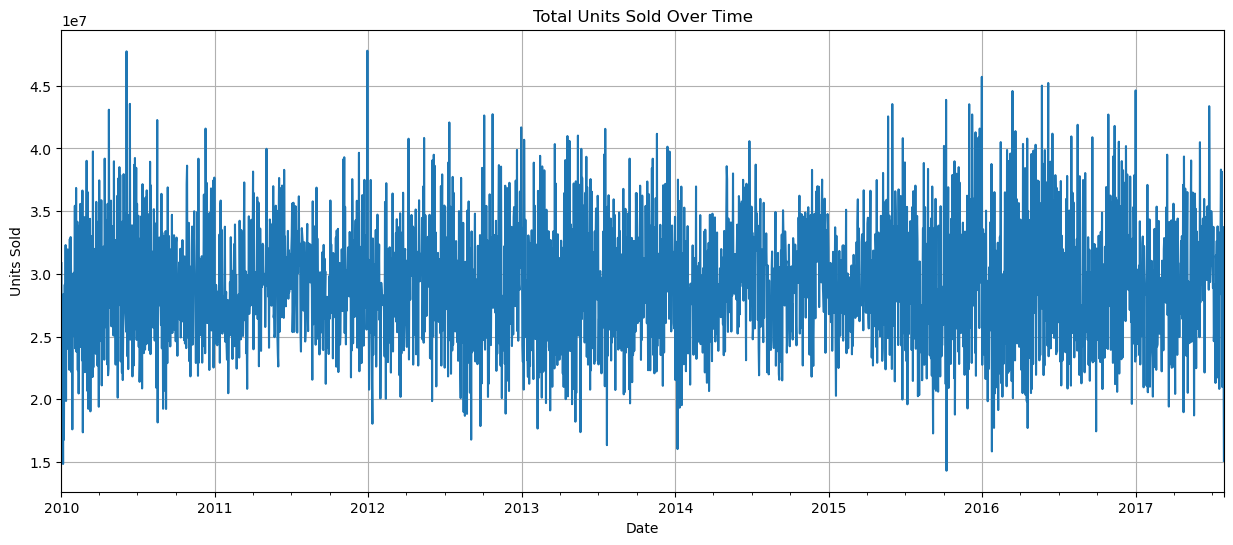

In [3]:
#Time Series Analysis of Units Sold
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
df.groupby('Order Date')['Units Sold'].sum().plot()
plt.title('Total Units Sold Over Time')
plt.ylabel('Units Sold')
plt.xlabel('Date')
plt.grid(True)
plt.show()

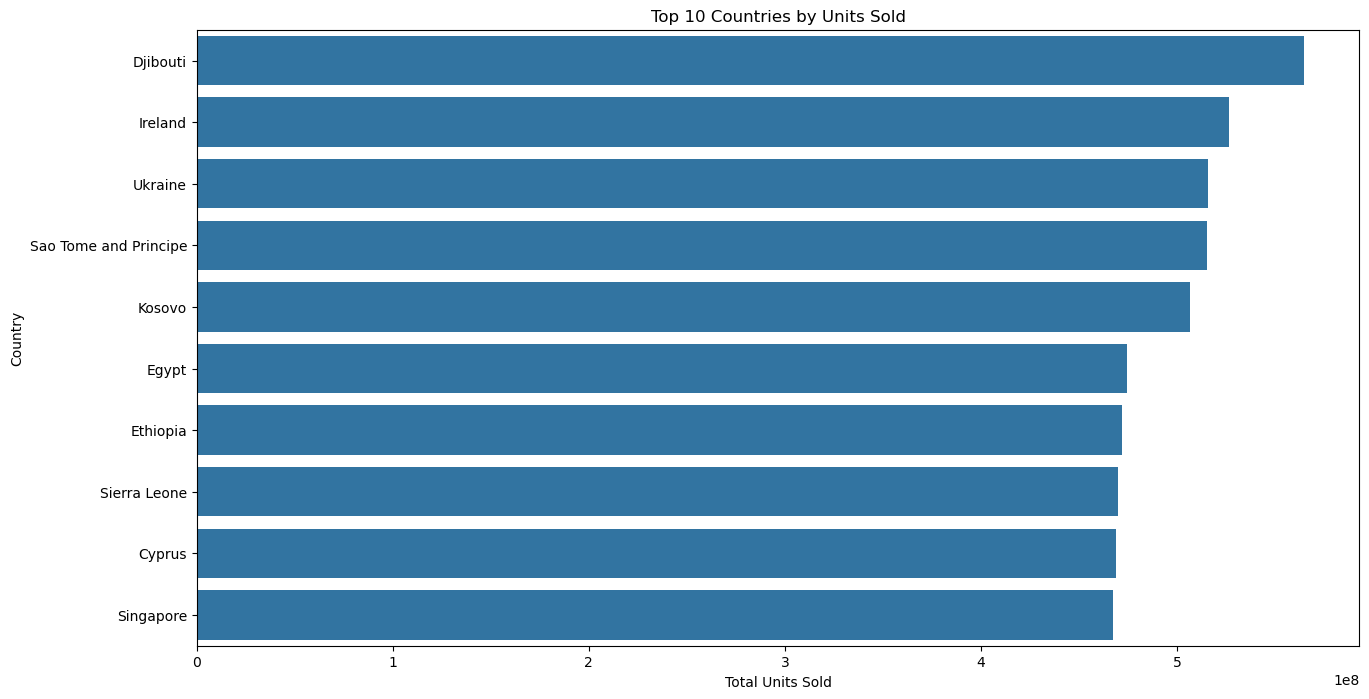

In [4]:
#Sales by Region and Country
plt.figure(figsize=(15, 8))
top_countries = df.groupby('Country')['Units Sold'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Units Sold')
plt.xlabel('Total Units Sold')
plt.ylabel('Country')
plt.show()

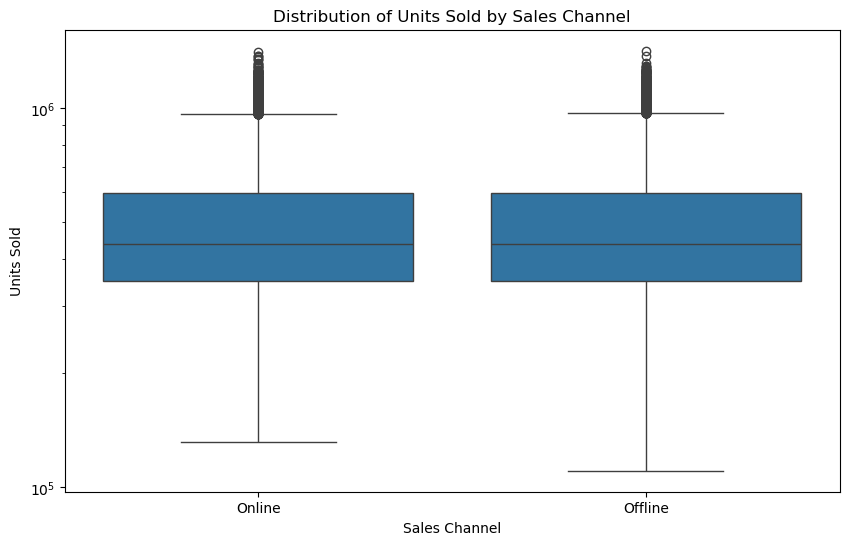

In [5]:
#Sales by Region and Country
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sales Channel', y='Units Sold', data=df)
plt.title('Distribution of Units Sold by Sales Channel')
plt.yscale('log')  # Using log scale due to wide distribution
plt.show()

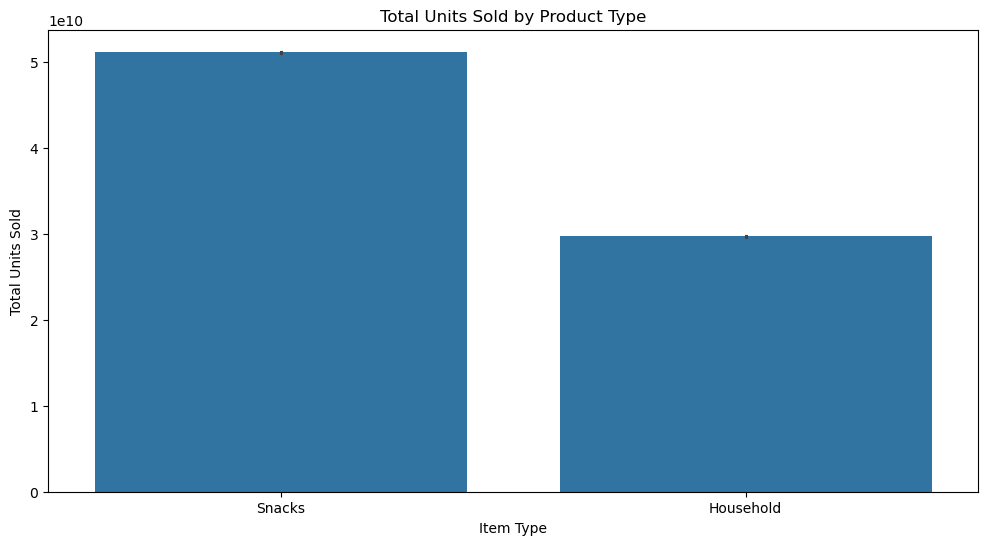

In [6]:
#Item Type Analysis
plt.figure(figsize=(12, 6))
sns.barplot(x='Item Type', y='Units Sold', data=df, estimator=sum)
plt.title('Total Units Sold by Product Type')
plt.ylabel('Total Units Sold')
plt.show()

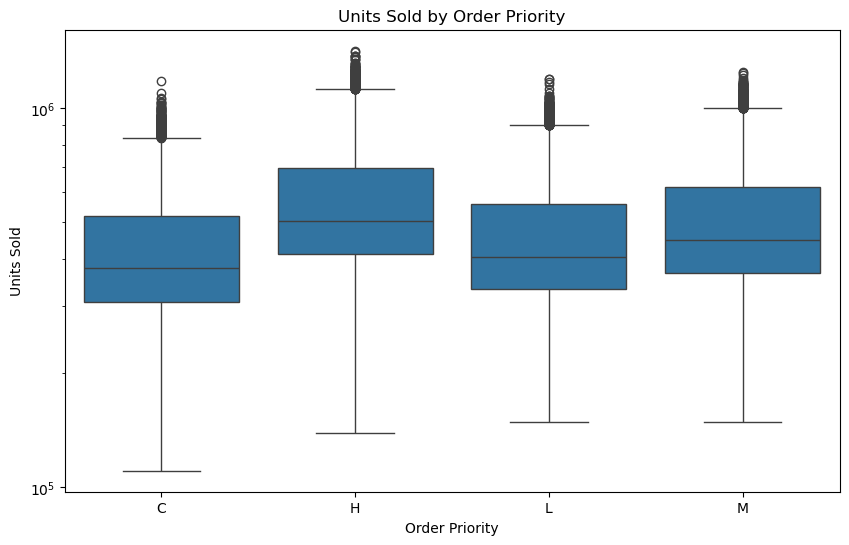

In [7]:
#Order Priority Impact
plt.figure(figsize=(10, 6))
sns.boxplot(x='Order Priority', y='Units Sold', data=df)
plt.title('Units Sold by Order Priority')
plt.yscale('log')
plt.show()

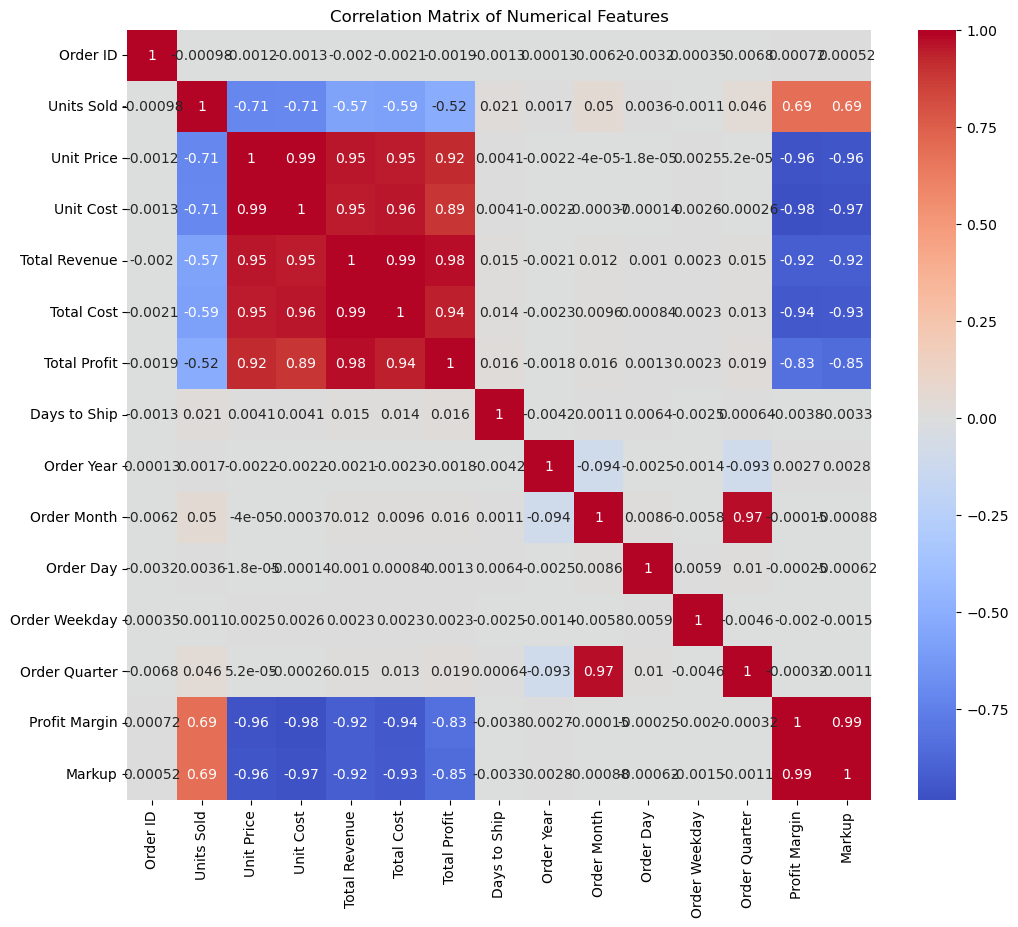

In [8]:
#Correlation Matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

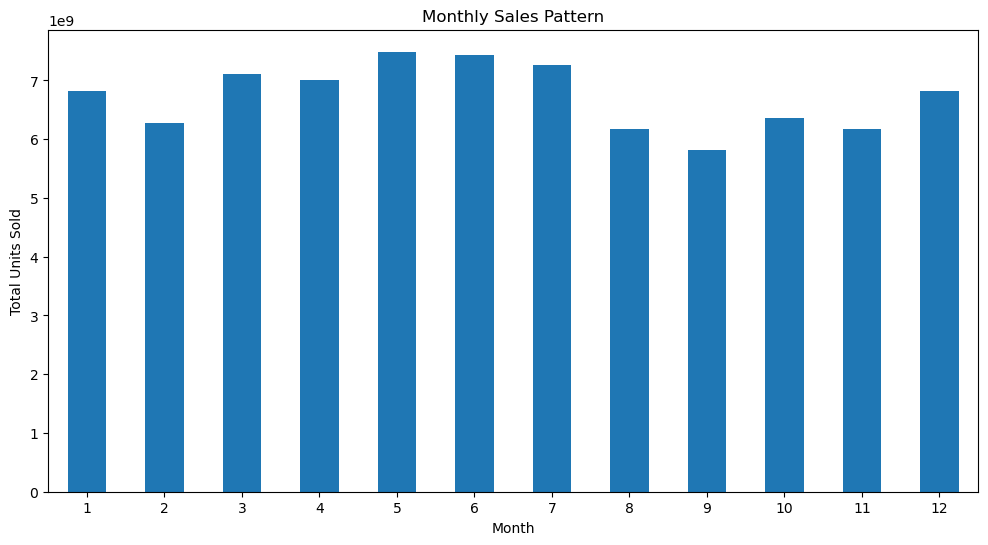

In [9]:
#Seasonal Patterns
plt.figure(figsize=(12, 6))
df.groupby('Order Month')['Units Sold'].sum().plot(kind='bar')
plt.title('Monthly Sales Pattern')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=0)
plt.show()

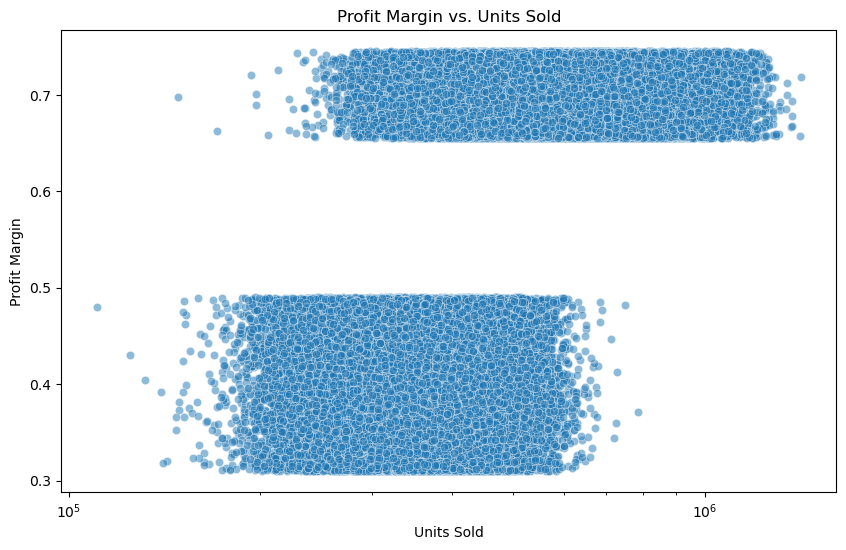

In [10]:
#Profitability vs. Units Sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Units Sold', y='Profit Margin', data=df, alpha=0.5)
plt.title('Profit Margin vs. Units Sold')
plt.xscale('log')
plt.show()

In [11]:
#Data Preparation for Modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target
X = df.drop(['Units Sold', 'Order ID', 'Total Revenue', 'Total Cost', 'Total Profit'], axis=1)
y = df['Units Sold']

# Define preprocessing for numeric and categorical columns
numeric_features = ['Unit Price', 'Unit Cost', 'Days to Ship', 'Order Year', 'Order Month', 
                   'Order Day', 'Order Weekday', 'Order Quarter', 'Profit Margin', 'Markup']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [12]:
# =============================================
# 1. Missing Values Analysis
# =============================================
# Check percentage of missing values in each column
missing_data = df.isnull().sum() / len(df) * 100
missing_data = missing_data[missing_data > 0]
print("Percentage of missing values:\n", missing_data)

# Handle missing values (example: fill numeric columns with median)
df.fillna({
    'Unit Price': df['Unit Price'].median(),
    'Units Sold': df['Units Sold'].mean()
}, inplace=True)

Percentage of missing values:
 Series([], dtype: float64)


Number of outliers in Units Sold: 2345


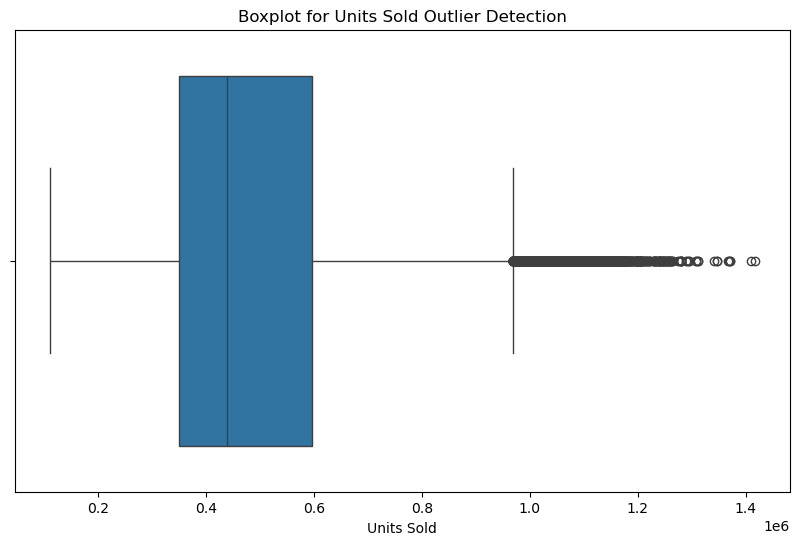

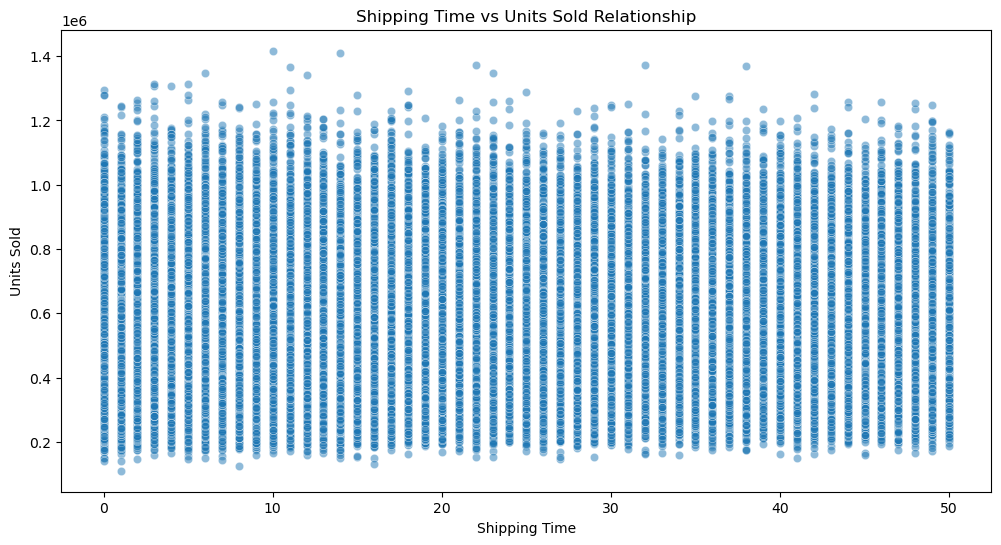

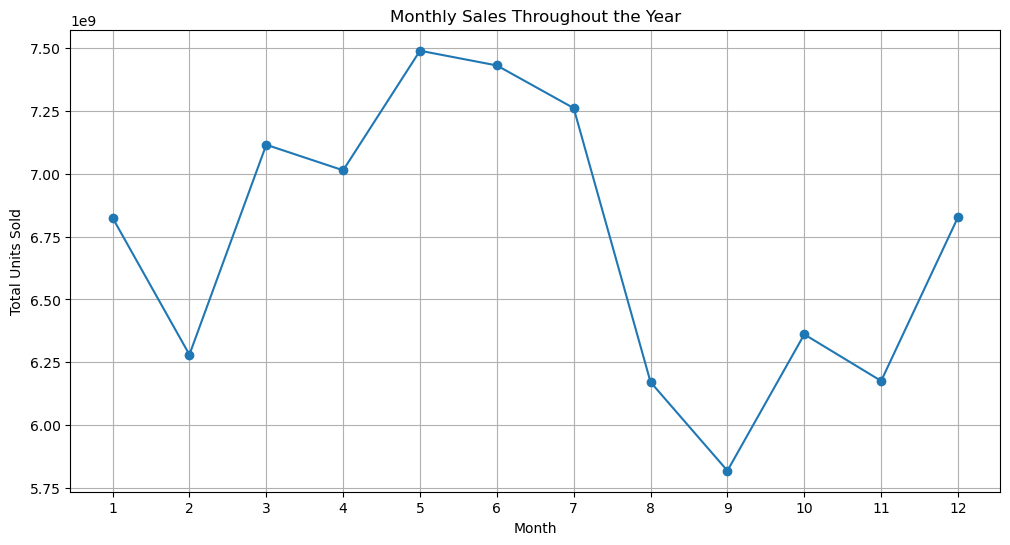

In [13]:

# =============================================
# 2. Outlier Detection
# =============================================
# Detect outliers in 'Units Sold' using IQR method
Q1 = df['Units Sold'].quantile(0.25)
Q3 = df['Units Sold'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Units Sold'] < (Q1 - 1.5*IQR)) | (df['Units Sold'] > (Q3 + 1.5*IQR))]
print("Number of outliers in Units Sold:", len(outliers))

# Visualize outliers with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Units Sold'])
plt.title('Boxplot for Units Sold Outlier Detection')
plt.show()

# =============================================
# 3. Shipping Time Analysis
# =============================================
# Calculate days between order and shipping
df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days

# Analyze shipping time impact on sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Shipping Time', y='Units Sold', data=df, alpha=0.5)
plt.title('Shipping Time vs Units Sold Relationship')
plt.show()
# =============================================
# 5. Seasonal Sales Analysis
# =============================================
# Analyze monthly sales patterns
monthly_sales = df.groupby('Order Month')['Units Sold'].sum()

# Plot seasonal trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Throughout the Year')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.xticks(range(1, 13))
plt.grid()
plt.show()


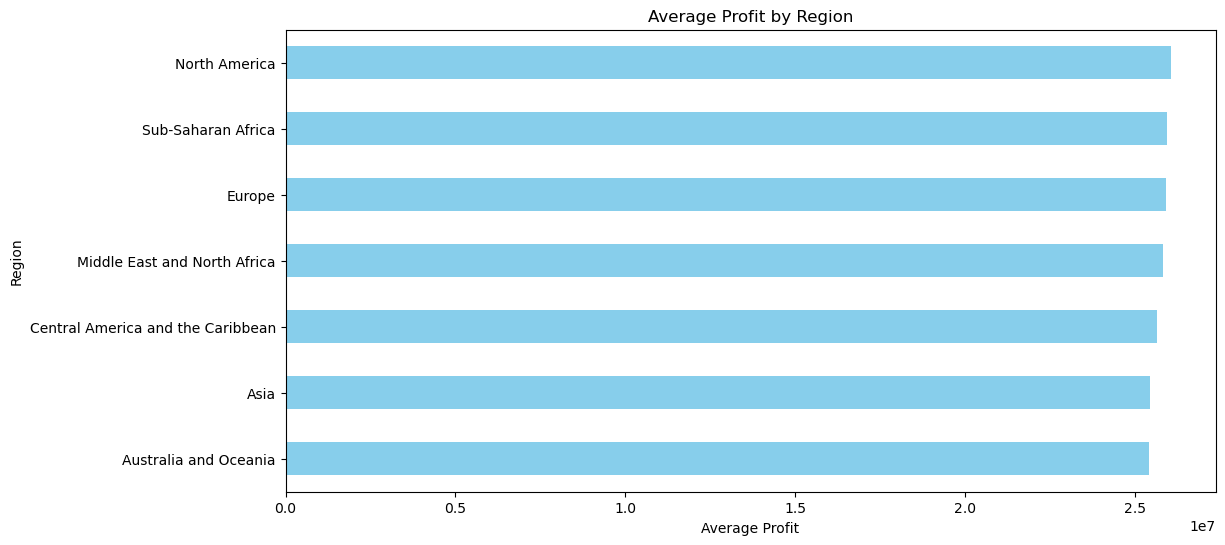

In [14]:
# =============================================
# 4. Profitability by Region
# =============================================
# Calculate average profit by region
profit_by_region = df.groupby('Region')['Total Profit'].mean().sort_values()

# Visualize regional profitability
plt.figure(figsize=(12, 6))
profit_by_region.plot(kind='barh', color='skyblue')
plt.title('Average Profit by Region')
plt.xlabel('Average Profit')
plt.ylabel('Region')
plt.show()


Correlation between Price and Units Sold: -0.71


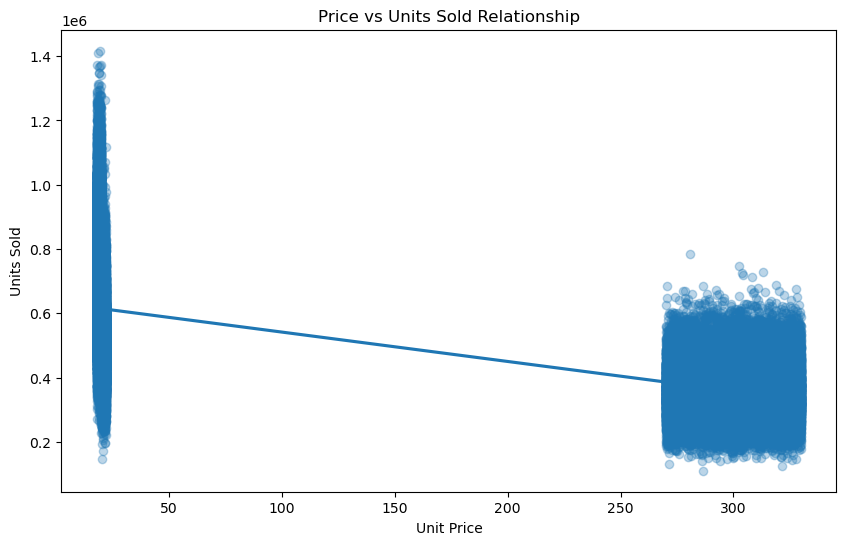

In [15]:
# =============================================
# 6. Price-Quantity Relationship
# =============================================
# Calculate correlation between price and sales
correlation = df[['Unit Price', 'Units Sold']].corr().iloc[0,1]
print(f"Correlation between Price and Units Sold: {correlation:.2f}")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.regplot(x='Unit Price', y='Units Sold', data=df, scatter_kws={'alpha':0.3})
plt.title('Price vs Units Sold Relationship')
plt.show()

Sales Channel Performance:
                 Units Sold  Total Profit
Sales Channel                           
Offline        40413910337  2.572368e+07
Online         40352072801  2.580257e+07


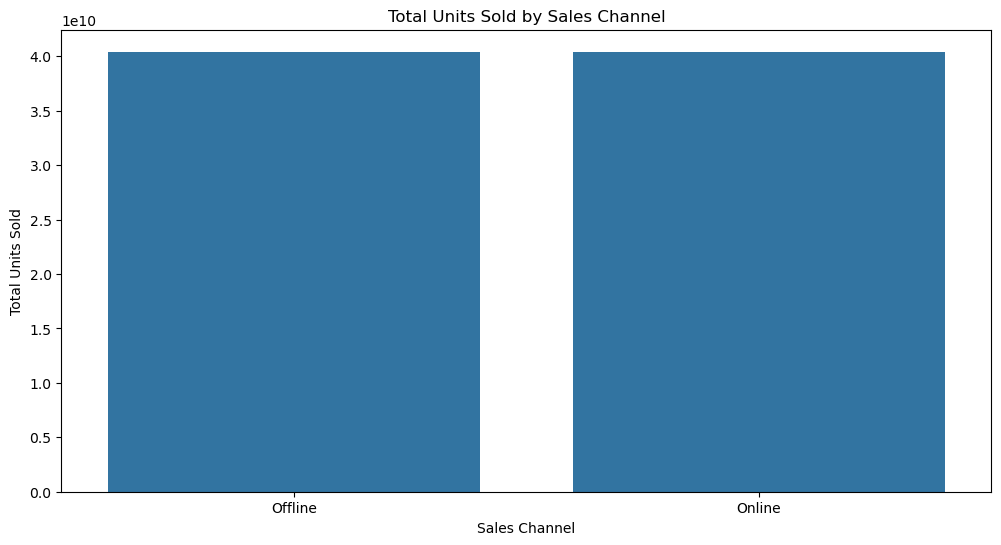

In [16]:
# =============================================
# 7. Sales Channel Performance
# =============================================
# Compare performance across channels
channel_performance = df.groupby('Sales Channel').agg({
    'Units Sold': 'sum',
    'Total Profit': 'mean'
}).sort_values('Units Sold', ascending=False)

print("Sales Channel Performance:\n", channel_performance)

# Visualize channel performance
plt.figure(figsize=(12, 6))
sns.barplot(x=channel_performance.index, y=channel_performance['Units Sold'])
plt.title('Total Units Sold by Sales Channel')
plt.ylabel('Total Units Sold')
plt.show()


In [23]:
# =============================================
# 8. Baseline Predictive Model
# =============================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Prepare data for modeling
X = df[['Unit Price', 'Unit Cost', 'Order Priority', 'Sales Channel', 'Order Month']]

# Custom one-hot encoding with simplified naming convention (removed "Encoded")
X_encoded = pd.get_dummies(X, columns=['Order Priority', 'Sales Channel', 'Order Month'],
                          prefix={'Order Priority': 'Order_Priority',
                                 'Sales Channel': 'Sales_Channel',
                                 'Order Month': 'Month'})

# Rename numerical features to match underscore format
X_encoded = X_encoded.rename(columns={
    'Unit Price': 'Unit_Price',
    'Unit Cost': 'Unit_Cost'
})

# Print all feature names
print("Final Feature Names:")
print([col for col in X_encoded.columns])

# Prepare target variable
y = df['Units Sold']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
predictions = model.predict(X_test)
print(f"\nModel MAE: {mean_absolute_error(y_test, predictions):.2f}")
print(f"Model R2 Score: {r2_score(y_test, predictions):.2f}")

Final Feature Names:
['Unit_Price', 'Unit_Cost', 'Order_Priority_C', 'Order_Priority_H', 'Order_Priority_L', 'Order_Priority_M', 'Sales_Channel_Offline', 'Sales_Channel_Online', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']

Model MAE: 65843.13
Model R2 Score: 0.77


In [25]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
import joblib
import time

# =============================================
# Feature Engineering
# =============================================

# Convert date columns to datetime
df['Order_Date'] = pd.to_datetime(df['Order Date'])
df['Ship_Date'] = pd.to_datetime(df['Ship Date'])

# Create time-based features with consistent naming
df['Days_To_Ship'] = (df['Ship_Date'] - df['Order_Date']).dt.days
df['Order_Year'] = df['Order_Date'].dt.year
df['Order_Month'] = df['Order_Date'].dt.month
df['Order_Weekday'] = df['Order_Date'].dt.weekday
df['Is_Weekend'] = df['Order_Weekday'].isin([5, 6]).astype(int)
df['Quarter'] = df['Order_Date'].dt.quarter

# Create financial metrics with consistent naming
# First check if columns exist with any naming convention
total_profit_col = next((col for col in df.columns if 'profit' in col.lower() and 'total' in col.lower()), None)
total_revenue_col = next((col for col in df.columns if 'revenue' in col.lower() and 'total' in col.lower()), None)
unit_price_col = next((col for col in df.columns if 'price' in col.lower() and 'unit' in col.lower()), None)
unit_cost_col = next((col for col in df.columns if 'cost' in col.lower() and 'unit' in col.lower()), None)

if total_profit_col and total_revenue_col:
    df['Profit_Margin'] = df[total_profit_col] / df[total_revenue_col]
if unit_price_col and unit_cost_col:
    df['Markup'] = (df[unit_price_col] - df[unit_cost_col]) / df[unit_cost_col]

# =============================================
# Data Preprocessing
# =============================================

# Define numeric and categorical features
numeric_features = [col for col in ['Unit_Price', 'Unit_Cost', 'Days_To_Ship', 'Order_Year', 
                   'Order_Month', 'Profit_Margin', 'Markup', 'Quarter'] if col in df.columns]

categorical_features = [col for col in ['Region', 'Item_Type', 'Sales_Channel', 'Order_Priority'] 
                       if col in df.columns]

# Custom transformer to get clean feature names
class CleanOneHotEncoder(OneHotEncoder):
    def get_feature_names_out(self, input_features=None):
        names = super().get_feature_names_out(input_features)
        return [f"{feature}_{name.split('_')[-1]}" for feature, name in zip(input_features, names)]

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', CleanOneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='drop')

# =============================================
# Model Training
# =============================================

# Prepare X and y
X = df[numeric_features + categorical_features]
y = df['Units_Sold'] if 'Units_Sold' in df.columns else df['Units Sold']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models with early stopping where possible
models = {
    'Random_Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'Gradient_Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        # Get feature names
        if name == 'Random_Forest':
            feature_names = numeric_features + list(pipeline.named_steps['preprocessor']
                                                  .named_transformers_['cat']
                                                  .named_steps['onehot']
                                                  .get_feature_names_out(categorical_features))
            print("\nFeature Names:")
            print(feature_names)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': root_mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'model': pipeline
        }
        results[name] = metrics
        
        # Print results
        print(f"\n{name} Results:")
        print(f"MAE: {metrics['MAE']:.2f}")
        print(f"RMSE: {metrics['RMSE']:.2f}")
        print(f"R2: {metrics['R2']:.2f}")
    
    except Exception as e:
        print(f"Error in {name}: {str(e)}")
        continue

# =============================================
# Hyperparameter Tuning
# =============================================
if 'Random_Forest' in results:
    param_grid = {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [5, 10],
        'regressor__min_samples_split': [5, 10]
    }

    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])

    grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluate best model
    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)

    print("\nTuned Random Forest Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred_rf):.2f}")
    print(f"R2: {r2_score(y_test, y_pred_rf):.2f}")

# =============================================
# Save Best Model
# =============================================
if results:
    best_model_name = min(results, key=lambda x: results[x]['MAE'])
    best_model = results[best_model_name]['model']

    # Save the model with versioning
    timestamp = time.strftime("%Y%m%d_%H%M")
    joblib.dump(best_model, f'best_model_{timestamp}.pkl')
    print(f"\nSaved best model ({best_model_name}) as 'best_model_{timestamp}.pkl'")
else:
    print("\nNo models were successfully trained.")


Feature Names:
['Days_To_Ship', 'Order_Year', 'Order_Month', 'Profit_Margin', 'Markup', 'Quarter', 'Region_Asia']

Random_Forest Results:
MAE: 92138.67
RMSE: 123489.86
R2: 0.54

XGBoost Results:
MAE: 92715.04
RMSE: 124314.56
R2: 0.53
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 132646, number of used features: 13
[LightGBM] [Info] Start training from score 487004.700308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [ ]:
import pandas as pd

df.to_pickle("Household_snacks.pkl")

